#  Choose Publicly avaliable data

Kaggle(www.kaggle.com)
 - SeoulBikeData(Seoul Bike Sharing Demand Prediction - Mendeley Data)

#  Explain the details of data

서울시 자전거 대여 데이터 셋 ( 파일명: SeoulBikeData.csv )
 - 2017년 12월 1일부터 2018년 11월 30일까지의 서울시의 자전거 대여와 관련된 데이터 셋
 - 자전거 대여 날짜와 해당 날짜의 날씨와 관련된 변수(Temperature(℃), Humidity(%) 등)가 존재함

데이터 변수 소개
1. Date : 자전거 대여 날짜(object)
2. Rented Bike Count : 자전거 대여 수(int64)
3. Hour : 자전거 대여 시각(시)(int64)
4. Temperature(℃) : 온도(float64)
5. Humidity(%) : 습도(int64)
6. Wind speed (m/s) : 풍속(float64)
7. Visibility (10m) : 가시거리(물체나 빛이 분명하게 보이는 최대 거리)(int64)
8. Dew point Temperature(℃) : 수증기를 포함하는 공기를 냉각했을 때, 응결이 시작되는 온도(float64)
9. Solar Radiation (MJ/m2): 지표면에 도달한 태양 복사에너지(float64)
10. Rainfall(mm) : 강수량(float64)
11. Snowfall (cm) : 강설량(float64)
12. Seasons : 계절(object)
13. Holiday : 휴일 유무(object)
14. Functioning Day : 자전거 대여 서비스 운영 여부(object)

# 1. Loading Library & Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

import optuna
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv('SeoulBikeData.csv', encoding='CP949')
df.head()

,Date,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(캜)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(캜)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

# 2. Data Preprocessing(+EDA)

### 2.0 rename variable

In [4]:
df=df.rename(columns={'Temperature(캜)':'Temperature',
                      'Humidity(%)':'Humidity',
                      'Wind speed (m/s)': 'Wind speed',
                      'Visibility (10m)': 'Visibility',
                      'Dew point temperature(캜)': 'Dew point temperature',
                      'Solar Radiation (MJ/m2)': 'Solar Radiation',
                      'Rainfall(mm)':'Rainfall',
                      'Snowfall (cm)':'Snowfall'})

### 2.1 Data Cleaning

#### 1) Dealing with missing values 
결측치는 존재하지 않음

In [5]:
df.isnull().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

#### 2) Handing duplicate values
Date와 Hour 기준으로, 중복값은 존재하지 않음

In [6]:
df[df.duplicated(subset=['Date', 'Hour'])]

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day


### 2.2 make new variable(+ Data visualization) & Dropping unnessery variable

#### 1) Date 변수를 이용해 year, month, day 변수 생성
년, 월, 일에 따른 Rented Bike Count를 확인하기 위해, year, month, day 변수 생성

In [7]:
df['year'] = df['Date'].str[6:10].astype('int')
df['month'] = df['Date'].str[3:5].astype('int')
df['day'] = df['Date'].str[:2].astype('int')
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [8]:
df1=df.drop(columns='Date')

#### 2) Sun 변수 생성 & Date 변수 제거
month, Hour에 따라, Sunday와 나머지 요일의 차이가 있는 것으로 확인됨  
또한 더 이상 사용하지 않는 Date 변수 제거

In [9]:
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

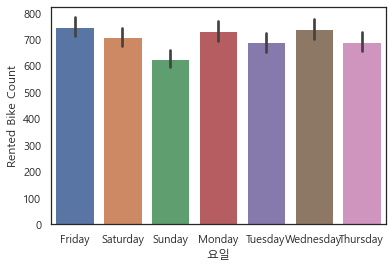

In [10]:
df['요일'] = df['Date'].dt.day_name()
sns.barplot(x=df['요일'], y=df['Rented Bike Count'])
plt.show()

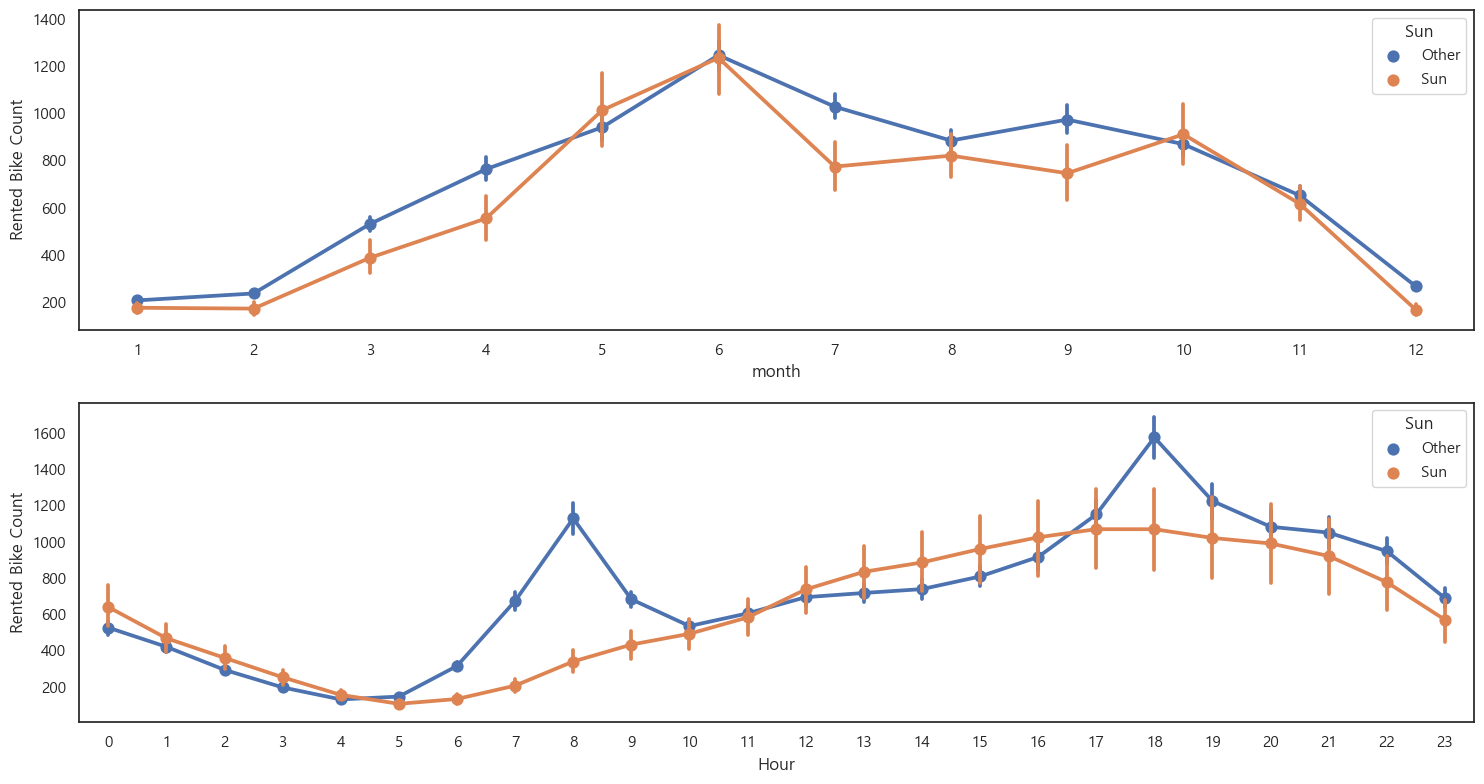

In [11]:
df.loc[df['요일'] == 'Sunday', 'Sun'] = 'Sun'
df.loc[df['요일'] != 'Sunday', 'Sun'] = 'Other'
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(15,8), dpi=100)
sns.pointplot(data=df, x="month", y="Rented Bike Count",ax=axs[0],hue="Sun")
sns.pointplot(data=df, x="Hour", y="Rented Bike Count",ax=axs[1],hue="Sun")
plt.tight_layout()

In [12]:
df=df.drop(columns=['요일'])

#### 3) year 변수 제거
17년과 18년의 겹치는 month, day가 없으므로, 중요하지 않다고 판단함

In [13]:
df_2017=df[df['year']==2017]
df_2018=df[df['year']==2018]
print(df_2017[['year', 'month', 'day']])
print(df_2018[['year', 'month', 'day']])

     year  month  day
0    2017     12    1
1    2017     12    1
2    2017     12    1
3    2017     12    1
4    2017     12    1
..    ...    ...  ...
739  2017     12   31
740  2017     12   31
741  2017     12   31
742  2017     12   31
743  2017     12   31

[744 rows x 3 columns]
      year  month  day
744   2018      1    1
745   2018      1    1
746   2018      1    1
747   2018      1    1
748   2018      1    1
...    ...    ...  ...
8755  2018     11   30
8756  2018     11   30
8757  2018     11   30
8758  2018     11   30
8759  2018     11   30

[8016 rows x 3 columns]


In [14]:
# df=df.drop(columns='year')

### 2.3 Data Transformation

#### 0) Category variables and their unique values

In [15]:
print('Seasons : ', df['Seasons'].unique())
print('Sun : ', df['Sun'].unique())
print('Holiday : ', df['Holiday'].unique())
print('Functioning Day : ' , df['Functioning Day'].unique())

Seasons :  ['Winter' 'Spring' 'Summer' 'Autumn']
Sun :  ['Other' 'Sun']
Holiday :  ['No Holiday' 'Holiday']
Functioning Day :  ['Yes' 'No']


#### 1) Seasons - One hot encoding

다음은 계절의 범위를 나타낸다.  
Seasons에 따른 Rented Bike Count의 차이가 있는 것으로 보여, one hot encoding하는 것이 적절함.  
1. Winter : 12 ~ 2
2. Spring : 3 ~ 5
3. Summer : 6 ~ 8
4. Autumn : 9 ~ 11

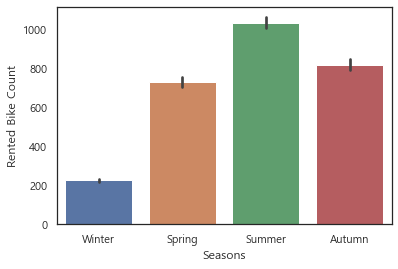

In [16]:
sns.barplot(x=df['Seasons'], y=df['Rented Bike Count'])
plt.show()

#### 2) 나머지 Category variable('Sun', 'Holiday', 'Functioning Day') - Label encoding
범주가 2개이므로, label encoding이나 one hot encoding을 해도 같은 결과를 얻음

In [17]:
# categories = ['Sun','Holiday','Functioning Day']
# encoder = LabelEncoder()
# for col in categories:
#        df[col] = pd.DataFrame(encoder.fit_transform(df[col]))

In [18]:
# df=pd.get_dummies(df, columns = ['Seasons'], drop_first=True)

### 2.4 Data Normalization

#### 1) Outlier detection

날씨와 관련된 Solar RAdiation, Rainfall, Snowfall, Wind spped 변수에서 Q3 + 1.5*IQR 보다 큰 이상치들이 확인되었으나, 사계절이 뚜렷한 우리나라의 날씨를 고려하여 제거하지 않았다.  
Rented Bike Count(Target)에서 또한 이상치가 발견되었지만, 퇴근시간인 18시(Hour = 18) 부근에서 자전거 대여량이 확 늘어나는 현상을 확인할 수 있어, 마찬가지로 제거하지 않았다.

Hour, Visibility, Temperature, Humidity, Dew point temperature 

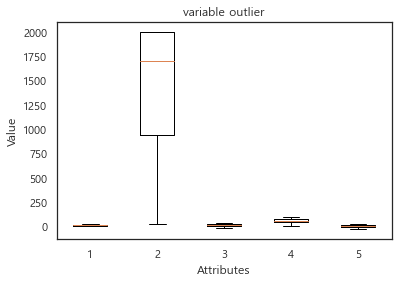

In [19]:
data_to_boxplot = [df['Hour'],
                   df['Visibility'],
                   df['Temperature'],
                   df['Humidity'],
                   df['Dew point temperature']
 ]
plt.boxplot(data_to_boxplot)
plt.title('variable outlier')
plt.xlabel('Attributes')
plt.ylabel('Value')
plt.show()

Solar Radiation, Rainfall, Snowfall, Wind speed

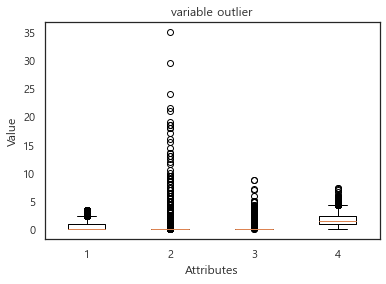

In [20]:
data_to_boxplot = [df['Solar Radiation'],
                   df['Rainfall'],
                   df['Snowfall'],
                   df['Wind speed']
 ]
plt.boxplot(data_to_boxplot)
plt.title('variable outlier')
plt.xlabel('Attributes')
plt.ylabel('Value')
plt.show()

Rented Bike Count(Target)

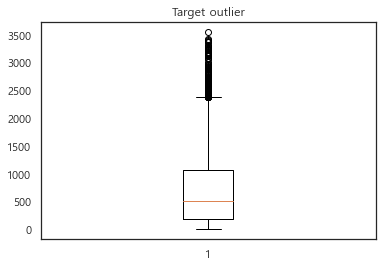

In [21]:
plt.boxplot(df['Rented Bike Count'])
plt.title('Target outlier')
plt.show()

#### *실제로 Rented Bike Count(Target)의 이상치가 18시 부근에 대부분 존재함을 확인

In [22]:
q3 = np.quantile(df['Rented Bike Count'],0.75)
q1 = np.quantile(df['Rented Bike Count'],0.25)
iqr = q3 - q1
high = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr
print('Q3+1.5*IQR : ', high)
print('Q1-1.5*IQR : ', low)

Q3+1.5*IQR :  2376.625
Q1-1.5*IQR :  -1120.375


In [23]:
df_Outlier = df[df['Rented Bike Count']>high]
df_Outlier.groupby(['month', 'day', 'Hour']).mean()[['Rented Bike Count', 'year']].head(30)

Rented Bike Count    year
month day Hour                           
4     2   18               2401.0  2018.0
      4   18               2402.0  2018.0
      9   18               2401.0  2018.0
      13  18               2404.0  2018.0
      16  18               2692.0  2018.0
      25  18               2807.0  2018.0
      26  18               2574.0  2018.0
      27  18               2577.0  2018.0
      30  18               2558.0  2018.0
5     4   18               2661.0  2018.0
      7   17               2392.0  2018.0
      9   18               3130.0  2018.0
          19               2405.0  2018.0
      11  18               2701.0  2018.0
      13  16               2379.0  2018.0
          17               2410.0  2018.0
      14  18               2906.0  2018.0
      15  18               2915.0  2018.0
      19  16               2479.0  2018.0
          18               2439.0  2018.0
      20  18               2403.0  2018.0
      21  18               3069.0  2018.0
          19               2450.0  2018.0
      23  18               3123.0  2018.0
          19               2454.0  2018.0
      24  18               2825.0  2018.0
      25  18               2916.0  2018.0
      28  18               3245.0  2018.0
          19               2656.0  2018.0
      30  18               3251.0  2018.0

#### 2) Rented Bike Count(Target)의 분포 확인 -> BoxCox 변환을 통해 정규분포로 변환가능

일부 model은 잔차의 정규분포를 가정하고 있기 때문에(선형회귀), Target의 분포를 정규분포의 형태로 변환하는 것은 잔차의 분포에도 영향을 미쳐 model의 성능을 향상 시킬 수 있다.

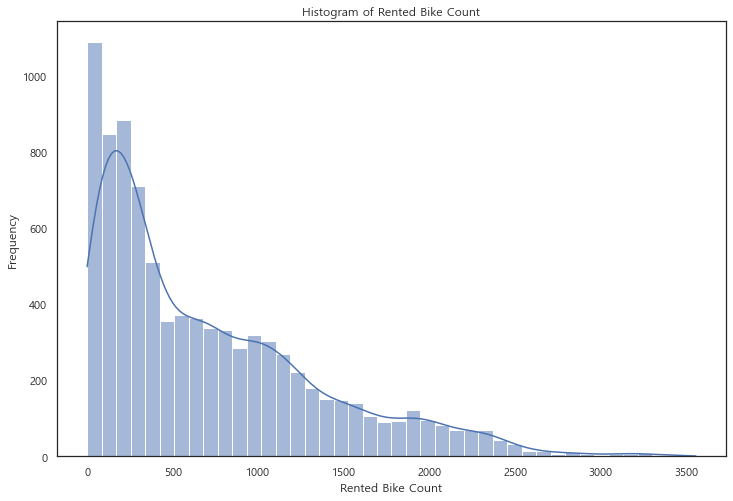

In [24]:
plt.figure(figsize=(12, 8))
sns.histplot(df['Rented Bike Count'], kde=True)
plt.title(f'Histogram of Rented Bike Count')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')
plt.show()

### 2.5 Feature Selection

#### 1) Correlation Heatmap

Temperature와 다중공선성이 있는 것으로 보이는 Dew point temperature는 제거하는 것이 적절해보인다.

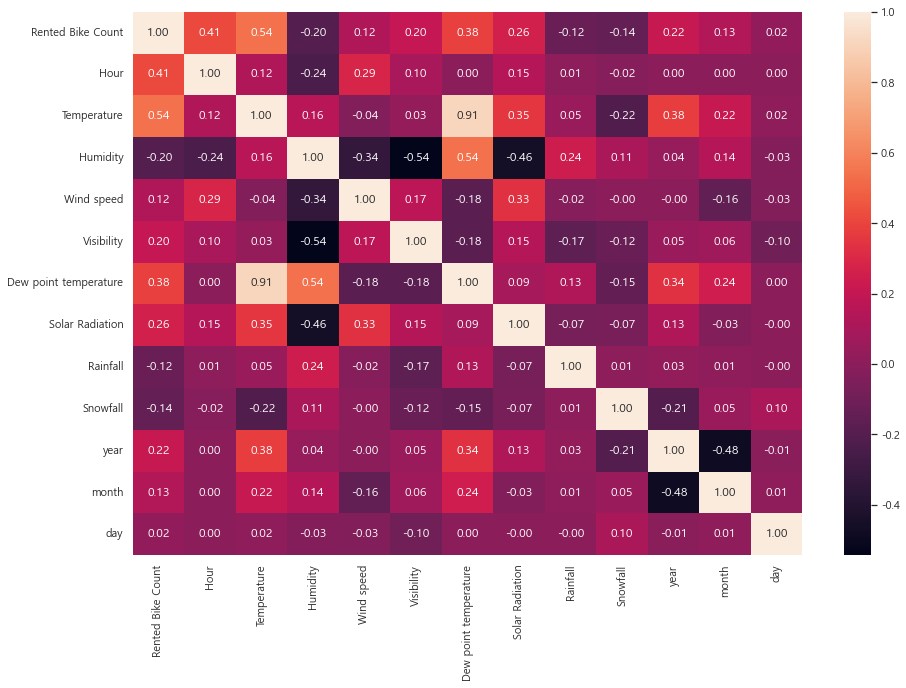

In [25]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', annot_kws={"size": 12})
plt.show()

In [26]:
# df=df.drop(columns=['Dew point temperature'])

### 2.6 Data preprocessing 결과

1. year, month, day 변수 생성
2. Sun 변수 생성 및 Date 변수 제거
3. year 변수 제거
4. Dew point temperature(multicollinearity 제거)
5. Category variable encoding  
   ('Sun', 'Holiday','Functioning Day' - Label encoding  
    'Seasons' - One hot encoding) 
6. Numeric variable Normalization  
   ('Rented Bike Count','Visibility', 'Temperature', 'Dew point temperature',   
    'Hour','Humidity','Solar Radiation', 'Rainfall', 'Snowfall', 'Wind speed' -> Box-Cox Transformer)

# 3 Data Analysis
model - Multiple Linear Regression, AdaBoost, RandomForest

## Level 1 

- Data preprocessing 전의 데이터 셋으로, year, month, day만 파생시킨 데이터 셋 이용(df1)
- Category variable encoding - Label encoding

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rented Bike Count      8760 non-null   int64  
 1   Hour                   8760 non-null   int64  
 2   Temperature            8760 non-null   float64
 3   Humidity               8760 non-null   int64  
 4   Wind speed             8760 non-null   float64
 5   Visibility             8760 non-null   int64  
 6   Dew point temperature  8760 non-null   float64
 7   Solar Radiation        8760 non-null   float64
 8   Rainfall               8760 non-null   float64
 9   Snowfall               8760 non-null   float64
 10  Seasons                8760 non-null   object 
 11  Holiday                8760 non-null   object 
 12  Functioning Day        8760 non-null   object 
 13  year                   8760 non-null   int32  
 14  month                  8760 non-null   int32  
 15  day 

#### 1) Data encoding

In [28]:
categories = ['Holiday','Functioning Day', 'Seasons']
encoder = LabelEncoder()
for col in categories:
    df1[col] = pd.DataFrame(encoder.fit_transform(df1[col]))

#### 2) Data split

In [29]:
X = df1.drop(columns=['Rented Bike Count'])
y = df1['Rented Bike Count'] 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

#### 3) Modeling 

MLR

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mlr_yhat = lr.predict(X_test)
print("R2 : ", r2_score(y_test, mlr_yhat))
print("RMSE : ", mean_squared_error(y_test, mlr_yhat, squared=False))

R2 :  0.5448908282355911
RMSE :  436.43266215552495


AdaBoost

In [31]:
ada = AdaBoostRegressor(n_estimators = 10, random_state=0)
ada.fit(X_train, y_train)
ada_yhat = ada.predict(X_test)
print("R2 : ", r2_score(y_test, ada_yhat))
print("RMSE : ", mean_squared_error(y_test, ada_yhat, squared=False))

R2 :  0.6516327883199484
RMSE :  381.83706887226367


RandomForest

In [32]:
rf = RandomForestRegressor(n_estimators = 10, random_state=0)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)
print("R2 : ", r2_score(y_test, rf_yhat))
print("RMSE : ", mean_squared_error(y_test, rf_yhat, squared=False))

R2 :  0.867475231971092
RMSE :  235.5092544885905


Stacking

In [33]:
base_models = [
    ('lr', LinearRegression()),
    ('ada', AdaBoostRegressor(n_estimators = 10, random_state=0)),
    ('rf', RandomForestRegressor(n_estimators = 10, random_state=0))
]

stacking_reg = StackingRegressor(estimators=base_models, 
                                 final_estimator=RandomForestRegressor(n_estimators = 10, random_state=0))
stacking_reg.fit(X_train, y_train)
stacking_reg_yhat = stacking_reg.predict(X_test)
print("R2 : ", r2_score(y_test, stacking_reg_yhat))
print("RMSE : ", mean_squared_error(y_test, stacking_reg_yhat, squared=False))

R2 :  0.8459284763836898
RMSE :  253.9338749970247


#### 4) R2 score , RMSE by model

In [34]:
import seaborn as sns
reg = pd.DataFrame({'regressor':['MLR', 'Ada Boost', 'Random Forest', 'Stacking Regressor'],
                    'R2':[round(r2_score(y_test, mlr_yhat),3),
                          round(r2_score(y_test, ada_yhat),3),
                          round(r2_score(y_test, rf_yhat),3),
                          round(r2_score(y_test, stacking_reg_yhat),3)],
                    'RMSE':[round(mean_squared_error(y_test, mlr_yhat, squared=False),2),
                            round(mean_squared_error(y_test, ada_yhat, squared=False),2), 
                            round(mean_squared_error(y_test, rf_yhat, squared=False),2),
                            round(mean_squared_error(y_test, stacking_reg_yhat, squared=False),2)]})

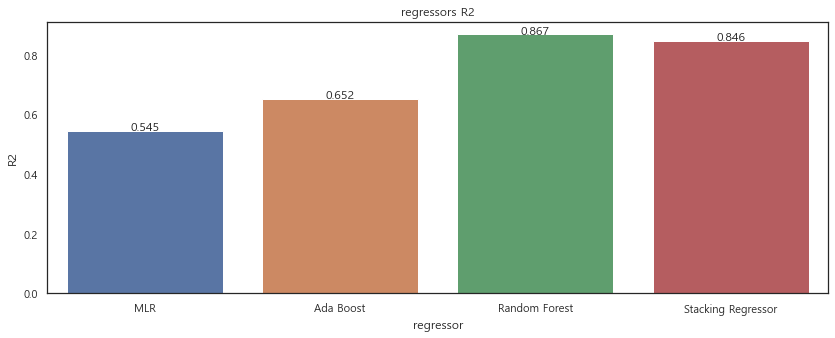

In [35]:
fig, ax = plt.subplots( figsize=(14,5) )
sns.barplot(x = reg['regressor'], y = reg['R2'])
plt.title('regressors R2')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) , 
            p.get_y() + p.get_height(), 
            f"{p.get_height():.3f}", 
            ha = 'center' ) 

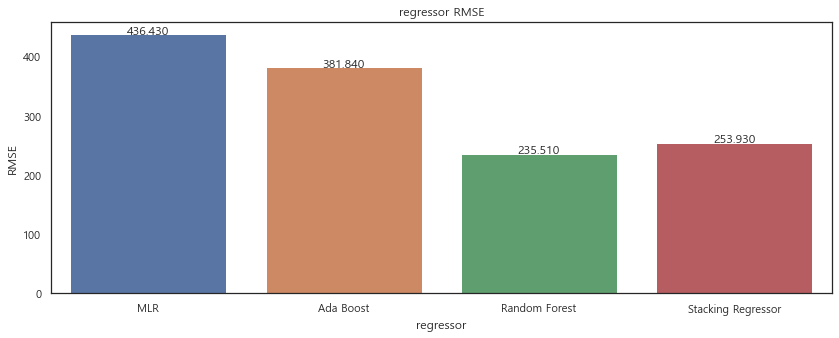

In [36]:
fig, ax = plt.subplots( figsize=(14,5) )
sns.barplot(x = reg['regressor'], y = reg['RMSE'])
plt.title('regressor RMSE')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) , 
            p.get_y() + p.get_height(), 
            f"{p.get_height():.3f}", 
            ha = 'center' ) 

# 4. strategy to improve the Accuracy of data analysis

## Level 2

기존의 데이터 셋(df)로 Data preprocessing과 함께 진행
- year, month, day 변수 생성
- Sun 변수 생성 및 Date 변수 제거
- year 변수 제거
- Dew point temperature(multicollinearity 제거)
- Category variable encoding  
   ('Sun', 'Holiday','Functioning Day' - Label encoding  
    'Seasons' - One hot encoding) 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   8760 non-null   datetime64[ns]
 1   Rented Bike Count      8760 non-null   int64         
 2   Hour                   8760 non-null   int64         
 3   Temperature            8760 non-null   float64       
 4   Humidity               8760 non-null   int64         
 5   Wind speed             8760 non-null   float64       
 6   Visibility             8760 non-null   int64         
 7   Dew point temperature  8760 non-null   float64       
 8   Solar Radiation        8760 non-null   float64       
 9   Rainfall               8760 non-null   float64       
 10  Snowfall               8760 non-null   float64       
 11  Seasons                8760 non-null   object        
 12  Holiday                8760 non-null   object        
 13  Fun

#### 1) Data encoding

In [38]:
categories = ['Sun','Holiday','Functioning Day']
encoder = LabelEncoder()
for col in categories:
    df[col] = pd.DataFrame(encoder.fit_transform(df[col]))
df=pd.get_dummies(df, columns = ['Seasons'], drop_first=True)

#### 2) Data split

In [39]:
X = df.drop(columns=['Rented Bike Count', 'Date', 'year', 'Dew point temperature'])
y = df['Rented Bike Count'] 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

#### 3) Modeling

MLR

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mlr_yhat = lr.predict(X_test)
print("R2 : ", r2_score(y_test, mlr_yhat))
print("RMSE : ", mean_squared_error(y_test, mlr_yhat, squared=False))

R2 :  0.5497284939673281
RMSE :  434.1068949141848


AdaBoost

In [41]:
ada = AdaBoostRegressor(n_estimators = 10, random_state=0)
ada.fit(X_train, y_train)
ada_yhat = ada.predict(X_test)
print("R2 : ", r2_score(y_test, ada_yhat))
print("RMSE : ", mean_squared_error(y_test, ada_yhat, squared=False))

R2 :  0.6631098156234276
RMSE :  375.49454322286545


RandomForest

In [42]:
rf = RandomForestRegressor(n_estimators = 10, random_state=0)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)
print("R2 : ", r2_score(y_test, rf_yhat))
print("RMSE : ", mean_squared_error(y_test, rf_yhat, squared=False))

R2 :  0.8824322282113228
RMSE :  221.82147814810048


Stacking

In [43]:
base_models = [
    ('lr', LinearRegression()),
    ('ada', AdaBoostRegressor(n_estimators = 10, random_state=0)),
    ('rf', RandomForestRegressor(n_estimators = 10, random_state=0))
]

stacking_reg = StackingRegressor(estimators=base_models, 
                                 final_estimator=RandomForestRegressor(n_estimators = 10, random_state=0))
stacking_reg.fit(X_train, y_train)
stacking_reg_yhat = stacking_reg.predict(X_test)
print("R2 : ", r2_score(y_test, stacking_reg_yhat))
print("RMSE : ", mean_squared_error(y_test, stacking_reg_yhat, squared=False))

R2 :  0.8585879108627145
RMSE :  243.27793484916566


#### 4) R2 score, RMSE by model

In [44]:
import seaborn as sns
reg2 = pd.DataFrame({'regressor':['MLR', 'Ada Boost', 'Random Forest', 'Stacking Regressor'],
                    'R2':[round(r2_score(y_test, mlr_yhat),3),
                          round(r2_score(y_test, ada_yhat),3),
                          round(r2_score(y_test, rf_yhat),3),
                          round(r2_score(y_test, stacking_reg_yhat),3)],
                    'RMSE':[round(mean_squared_error(y_test, mlr_yhat, squared=False),2),
                            round(mean_squared_error(y_test, ada_yhat, squared=False),2), 
                            round(mean_squared_error(y_test, rf_yhat, squared=False),2),
                            round(mean_squared_error(y_test, stacking_reg_yhat, squared=False),2)]})

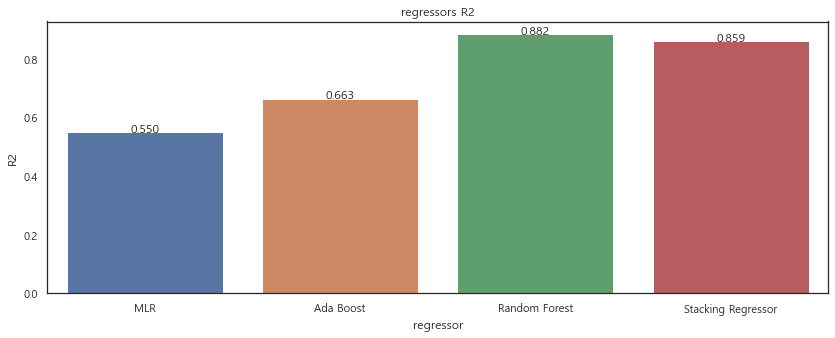

In [45]:
fig, ax = plt.subplots( figsize=(14,5) )
sns.barplot(x = reg2['regressor'], y = reg2['R2'])
plt.title('regressors R2')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) , 
            p.get_y() + p.get_height(), 
            f"{p.get_height():.3f}", 
            ha = 'center' ) 

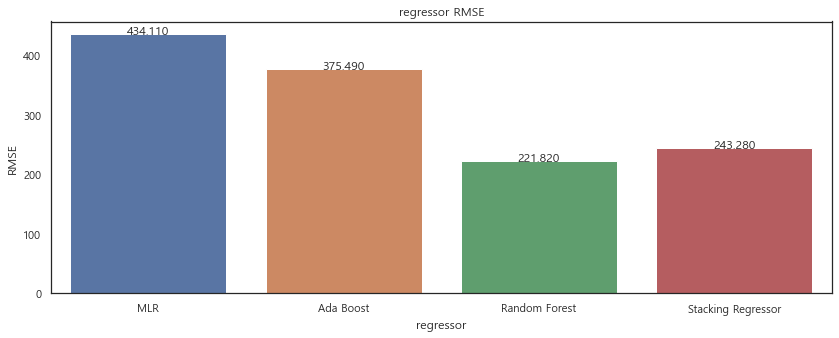

In [46]:
fig, ax = plt.subplots( figsize=(14,5) )
sns.barplot(x = reg2['regressor'], y = reg2['RMSE'])
plt.title('regressor RMSE')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) , 
            p.get_y() + p.get_height(), 
            f"{p.get_height():.3f}", 
            ha = 'center' ) 

## Level 3

Level 2의 preprocessing와 동일하게 진행 후,
- Rented Bike Count(Target) Normalization -> Rented Bike Count(Target)의 Boxcox 변환

#### 1) Rented Bike Count(Target)의 Boxcox 변환

In [47]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
df['Rented Bike Count'] = pd.DataFrame(pt.fit_transform(df[['Rented Bike Count']]))

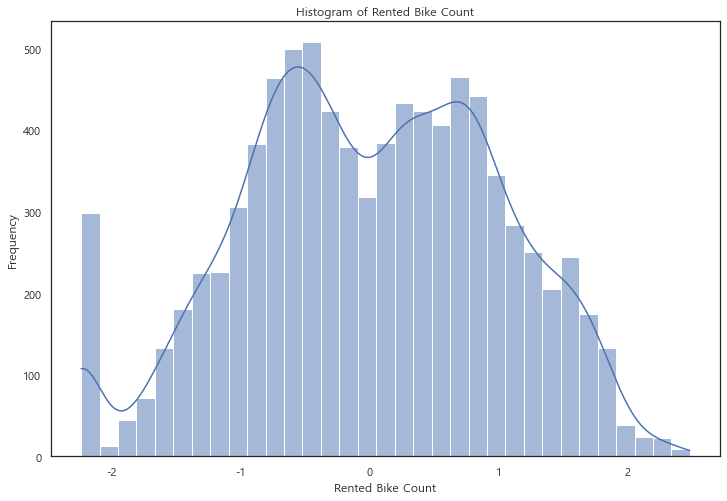

In [48]:
plt.figure(figsize=(12, 8))
sns.histplot(df['Rented Bike Count'], kde=True)
plt.title(f'Histogram of Rented Bike Count')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')
plt.show()

#### 2) Data split

In [49]:
X = df.drop(columns=['Rented Bike Count', 'Date', 'year', 'Dew point temperature'])
y = df['Rented Bike Count']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

#### 3) modeling

MLR

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mlr_yhat = lr.predict(X_test)
print("R2 : ", r2_score(y_test, mlr_yhat))
print("RMSE : ", mean_squared_error(y_test, mlr_yhat, squared=False))

R2 :  0.6914327470898296
RMSE :  0.5620219982134196


AdaBoost

In [51]:
ada = AdaBoostRegressor(n_estimators = 10, random_state=0)
ada.fit(X_train, y_train)
ada_yhat = ada.predict(X_test)
print("R2 : ", r2_score(y_test, ada_yhat))
print("RMSE : ", mean_squared_error(y_test, ada_yhat, squared=False))

R2 :  0.7047930548172237
RMSE :  0.5497201837534742


Random Forest

In [52]:
rf = RandomForestRegressor(n_estimators = 10, random_state=0)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)
print("R2 : ", r2_score(y_test, rf_yhat))
print("RMSE : ", mean_squared_error(y_test, rf_yhat, squared=False))

R2 :  0.9140583821011182
RMSE :  0.29660615586200695


Stacking

In [53]:
base_models = [
    ('lr', LinearRegression()),
    ('ada', AdaBoostRegressor(n_estimators = 10, random_state=0)),
    ('rf', RandomForestRegressor(n_estimators = 10, random_state=0))
]

stacking_reg = StackingRegressor(estimators=base_models, 
                                 final_estimator=RandomForestRegressor(n_estimators = 10, random_state=0))
stacking_reg.fit(X_train, y_train)
stacking_reg_yhat = stacking_reg.predict(X_test)
print("R2 : ", r2_score(y_test, stacking_reg_yhat))
print("RMSE : ", mean_squared_error(y_test, stacking_reg_yhat, squared=False))

R2 :  0.8936474062244495
RMSE :  0.329953272981202


#### 4) R2 score, RMSE by model

In [54]:
import seaborn as sns
reg3 = pd.DataFrame({'regressor':['MLR', 'Ada Boost', 'Random Forest', 'Stacking regressor'],
                    'R2':[round(r2_score(y_test, mlr_yhat),3),
                          round(r2_score(y_test, ada_yhat),3),
                          round(r2_score(y_test, rf_yhat),3),
                          round(r2_score(y_test, stacking_reg_yhat),3)],
                    'RMSE':[round(mean_squared_error(y_test, mlr_yhat, squared=False),2),
                            round(mean_squared_error(y_test, ada_yhat, squared=False),2), 
                            round(mean_squared_error(y_test, rf_yhat, squared=False),2),
                            round(mean_squared_error(y_test, stacking_reg_yhat, squared=False),2)]})

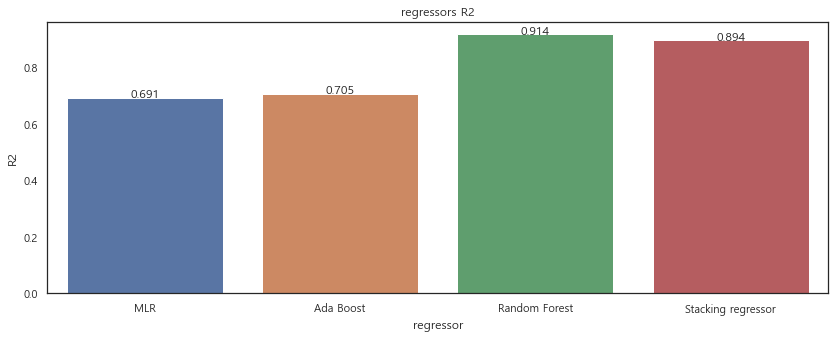

In [55]:
fig, ax = plt.subplots( figsize=(14,5) )
sns.barplot(x = reg3['regressor'], y = reg3['R2'])
plt.title('regressors R2')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) , 
            p.get_y() + p.get_height(), 
            f"{p.get_height():.3f}", 
            ha = 'center' ) 

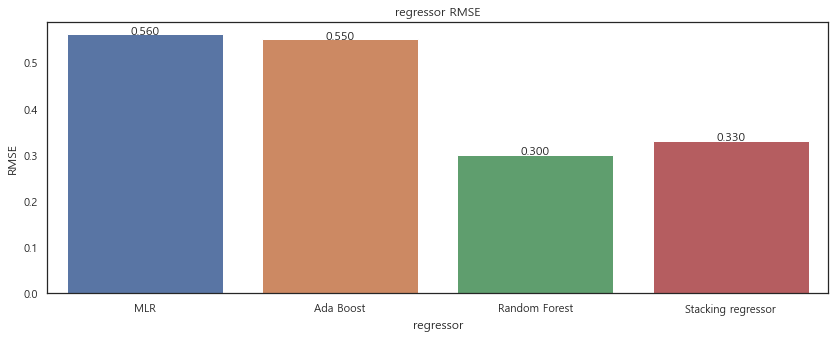

In [56]:
fig, ax = plt.subplots( figsize=(14,5) )
sns.barplot(x = reg3['regressor'], y = reg3['RMSE'])
plt.title('regressor RMSE')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) , 
            p.get_y() + p.get_height(), 
            f"{p.get_height():.3f}", 
            ha = 'center' ) 

## Level 4

Level3의 preprocessing과 동일함.
- 추가로, AdaBoost, RandomForest의 Hyperparameter 최적화

### 1. AdaBoost

In [57]:
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    n_estimators = trial.suggest_int('n_estimators', 1, 100)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 1.0, 2.0)

    base_classifier = DecisionTreeRegressor(max_depth=max_depth)
    model = AdaBoostRegressor(
        base_classifier,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=0
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    R2=r2_score(y_test, y_pred)
    return R2

In [58]:
# Optuna로 하이퍼파라미터 최적화 수행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-12-13 01:18:03,457] A new study created in memory with name: no-name-78bea2f5-0c32-48c6-8a18-c0bbc6154152
[I 2023-12-13 01:18:04,642] Trial 0 finished with value: 0.8913941733128461 and parameters: {'n_estimators': 73, 'max_depth': 7, 'learning_rate': 1.8662769304554772}. Best is trial 0 with value: 0.8913941733128461.
[I 2023-12-13 01:18:05,761] Trial 1 finished with value: 0.9049198518443452 and parameters: {'n_estimators': 52, 'max_depth': 9, 'learning_rate': 1.2258615679951923}. Best is trial 1 with value: 0.9049198518443452.
[I 2023-12-13 01:18:07,324] Trial 2 finished with value: 0.9223033334194767 and parameters: {'n_estimators': 42, 'max_depth': 16, 'learning_rate': 1.0967670089288561}. Best is trial 2 with value: 0.9223033334194767.
[I 2023-12-13 01:18:07,710] Trial 3 finished with value: 0.8818409578672457 and parameters: {'n_estimators': 20, 'max_depth': 7, 'learning_rate': 1.6401770512775822}. Best is trial 2 with value: 0.9223033334194767.
[I 2023-12-13 01:18:07,87

[I 2023-12-13 01:19:22,961] Trial 38 finished with value: 0.9212347465779922 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 1.2246512671978704}. Best is trial 33 with value: 0.9247881754007432.
[I 2023-12-13 01:19:25,959] Trial 39 finished with value: 0.9225099439638008 and parameters: {'n_estimators': 76, 'max_depth': 20, 'learning_rate': 1.362926982615022}. Best is trial 33 with value: 0.9247881754007432.
[I 2023-12-13 01:19:26,102] Trial 40 finished with value: 0.8438656250123896 and parameters: {'n_estimators': 6, 'max_depth': 6, 'learning_rate': 1.2431351524871397}. Best is trial 33 with value: 0.9247881754007432.
[I 2023-12-13 01:19:28,513] Trial 41 finished with value: 0.9216857858594224 and parameters: {'n_estimators': 60, 'max_depth': 19, 'learning_rate': 1.3386572297161938}. Best is trial 33 with value: 0.9247881754007432.
[I 2023-12-13 01:19:31,113] Trial 42 finished with value: 0.9220960129500797 and parameters: {'n_estimators': 67, 'max_depth': 17, 

[I 2023-12-13 01:20:57,530] Trial 76 finished with value: 0.9211336923283998 and parameters: {'n_estimators': 78, 'max_depth': 17, 'learning_rate': 1.3649269737867327}. Best is trial 59 with value: 0.925393151585801.
[I 2023-12-13 01:20:59,209] Trial 77 finished with value: 0.920777242473547 and parameters: {'n_estimators': 44, 'max_depth': 20, 'learning_rate': 1.171531736691695}. Best is trial 59 with value: 0.925393151585801.
[I 2023-12-13 01:21:01,935] Trial 78 finished with value: 0.921612271288279 and parameters: {'n_estimators': 73, 'max_depth': 18, 'learning_rate': 1.3385773661093174}. Best is trial 59 with value: 0.925393151585801.
[I 2023-12-13 01:21:02,141] Trial 79 finished with value: 0.7344732975637891 and parameters: {'n_estimators': 16, 'max_depth': 3, 'learning_rate': 1.2521557532509608}. Best is trial 59 with value: 0.925393151585801.
[I 2023-12-13 01:21:04,541] Trial 80 finished with value: 0.9249052391914004 and parameters: {'n_estimators': 62, 'max_depth': 19, 'lear

####  최적화된 AdaBoost parameter

In [59]:
# 최적의 하이퍼파라미터 및 결과 출력
best_ada_params = study.best_params
best_ada_r2 = study.best_value
print(f"Best Hyperparameters: {best_ada_params}")
print(f"Best R2: {best_ada_r2}")

Best Hyperparameters: {'n_estimators': 81, 'max_depth': 17, 'learning_rate': 1.437818934651844}
Best R2: 0.9269280045200702


####  AdaBoost

In [60]:
ada = AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=18),
        n_estimators=91,
        learning_rate=1.6293826188251432,
        random_state=0
)
ada.fit(X_train, y_train)
ada_yhat = ada.predict(X_test)
print("R2 : ", r2_score(y_test, ada_yhat))
print("RMSE : ", mean_squared_error(y_test, ada_yhat, squared=False))

R2 :  0.9250915991555909
RMSE :  0.2769132013979681


C:\Users\gksxk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\gksxk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


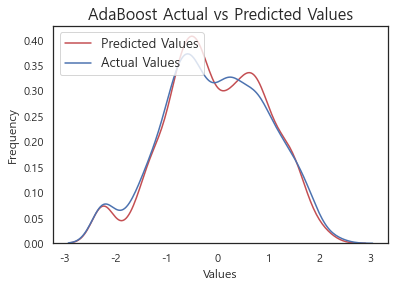

In [61]:
sns.distplot(ada_yhat, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('AdaBoost Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

### 2. RandomForest 

In [64]:
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=1,
        random_state=0
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    R2=r2_score(y_test, y_pred)
    return R2

In [65]:
# Optuna로 하이퍼파라미터 최적화 수행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-12-11 02:55:25,404] A new study created in memory with name: no-name-30306ba2-de37-4b10-8b01-5eec3c2acc6e
[I 2023-12-11 02:55:26,575] Trial 0 finished with value: 0.8397096877620156 and parameters: {'n_estimators': 87, 'max_depth': 6, 'min_samples_split': 14}. Best is trial 0 with value: 0.8397096877620156.
[I 2023-12-11 02:55:32,319] Trial 1 finished with value: 0.9206185876220913 and parameters: {'n_estimators': 224, 'max_depth': 12, 'min_samples_split': 2}. Best is trial 1 with value: 0.9206185876220913.
[I 2023-12-11 02:55:39,228] Trial 2 finished with value: 0.9203813573281936 and parameters: {'n_estimators': 271, 'max_depth': 14, 'min_samples_split': 13}. Best is trial 1 with value: 0.9206185876220913.
[I 2023-12-11 02:55:42,624] Trial 3 finished with value: 0.9222310706393971 and parameters: {'n_estimators': 124, 'max_depth': 15, 'min_samples_split': 8}. Best is trial 3 with value: 0.9222310706393971.
[I 2023-12-11 02:55:44,954] Trial 4 finished with value: 0.84144514523

[I 2023-12-11 02:58:05,857] Trial 40 finished with value: 0.9228621155657512 and parameters: {'n_estimators': 245, 'max_depth': 16, 'min_samples_split': 9}. Best is trial 34 with value: 0.9248017438248558.
[I 2023-12-11 02:58:12,781] Trial 41 finished with value: 0.924524156819175 and parameters: {'n_estimators': 247, 'max_depth': 19, 'min_samples_split': 6}. Best is trial 34 with value: 0.9248017438248558.
[I 2023-12-11 02:58:19,404] Trial 42 finished with value: 0.924439190796251 and parameters: {'n_estimators': 234, 'max_depth': 20, 'min_samples_split': 6}. Best is trial 34 with value: 0.9248017438248558.
[I 2023-12-11 02:58:27,454] Trial 43 finished with value: 0.9249528897314878 and parameters: {'n_estimators': 274, 'max_depth': 18, 'min_samples_split': 4}. Best is trial 43 with value: 0.9249528897314878.
[I 2023-12-11 02:58:35,504] Trial 44 finished with value: 0.9250512872024369 and parameters: {'n_estimators': 277, 'max_depth': 19, 'min_samples_split': 4}. Best is trial 44 with

[I 2023-12-11 03:03:34,048] Trial 80 finished with value: 0.61427624513316 and parameters: {'n_estimators': 212, 'max_depth': 3, 'min_samples_split': 12}. Best is trial 62 with value: 0.9254460234332895.
[I 2023-12-11 03:03:42,431] Trial 81 finished with value: 0.9254583564859014 and parameters: {'n_estimators': 257, 'max_depth': 19, 'min_samples_split': 2}. Best is trial 81 with value: 0.9254583564859014.
[I 2023-12-11 03:03:50,340] Trial 82 finished with value: 0.9253054702783625 and parameters: {'n_estimators': 243, 'max_depth': 20, 'min_samples_split': 3}. Best is trial 81 with value: 0.9254583564859014.
[I 2023-12-11 03:03:58,707] Trial 83 finished with value: 0.925416737142413 and parameters: {'n_estimators': 258, 'max_depth': 19, 'min_samples_split': 2}. Best is trial 81 with value: 0.9254583564859014.
[I 2023-12-11 03:04:06,755] Trial 84 finished with value: 0.9252530000585887 and parameters: {'n_estimators': 254, 'max_depth': 19, 'min_samples_split': 3}. Best is trial 81 with 

####  최적화된 RandomForest parameter

In [66]:
# 최적의 하이퍼파라미터 및 결과 출력
best_rf_params = study.best_params
best_rf_r2 = study.best_value
print(f"Best Hyperparameters: {best_rf_params}")
print(f"Best R2: {best_rf_r2}")

Best Hyperparameters: {'n_estimators': 236, 'max_depth': 18, 'min_samples_split': 2}
Best R2: 0.9255055338652467


#### RandomForest

In [68]:
rf = RandomForestRegressor(
        n_estimators=236,
        max_depth=18,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=0
)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)
print("R2 : ", r2_score(y_test, rf_yhat))
print("RMSE : ", mean_squared_error(y_test, rf_yhat, squared=False))

R2 :  0.9255055338652467
RMSE :  0.27614704718226263


C:\Users\gksxk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\gksxk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


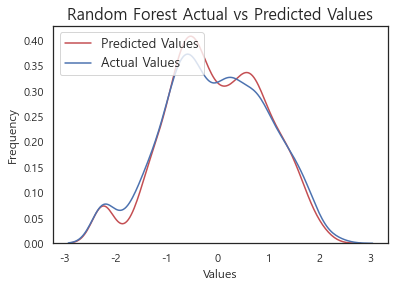

In [78]:
sns.distplot(rf_yhat, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Random Forest Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

### 3. stacking

#### Stacking

In [70]:
base_models = [
    ('lr', LinearRegression()),
    ('ada', AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=18),
        n_estimators=91,
        learning_rate=1.6293826188251432,
        random_state=0
)),
    ('rf', RandomForestRegressor(
        n_estimators=236,
        max_depth=18,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=0
))
]

stacking_reg = StackingRegressor(estimators=base_models, 
                                 final_estimator=RandomForestRegressor(n_estimators = 10, random_state=0))
stacking_reg.fit(X_train, y_train)
stacking_reg_yhat = stacking_reg.predict(X_test)
print("R2 : ", r2_score(y_test, stacking_reg_yhat))
print("RMSE : ", mean_squared_error(y_test, stacking_reg_yhat, squared=False))

R2 :  0.9112232613720862
RMSE :  0.3014588172158681


C:\Users\gksxk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\gksxk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


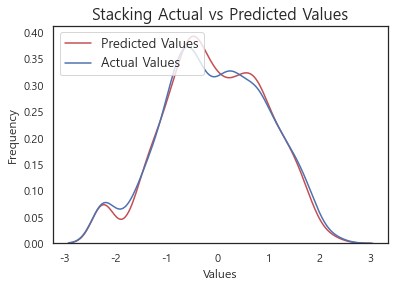

In [80]:
sns.distplot(stacking_reg_yhat, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Stacking Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

### 4. R2, RMSE by model

In [71]:
import seaborn as sns
final = pd.DataFrame({'regressor':['MLR', 'Ada Boost', 'Random Forest', 'Stacking regressor'],
                    'R2':[round(r2_score(y_test, mlr_yhat),3),
                          round(r2_score(y_test, ada_yhat),3),
                          round(r2_score(y_test, rf_yhat),3),
                          round(r2_score(y_test, stacking_reg_yhat),3)],
                    'RMSE':[round(mean_squared_error(y_test, mlr_yhat, squared=False),2),
                            round(mean_squared_error(y_test, ada_yhat, squared=False),2), 
                            round(mean_squared_error(y_test, rf_yhat, squared=False),2),
                            round(mean_squared_error(y_test, stacking_reg_yhat, squared=False),2)]})


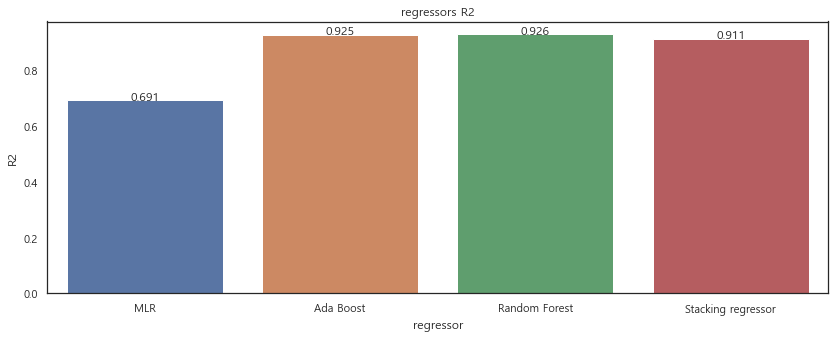

In [72]:
fig, ax = plt.subplots( figsize=(14,5) )
sns.barplot(x = final['regressor'], y = final['R2'])
plt.title('regressors R2')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) , 
            p.get_y() + p.get_height(), 
            f"{p.get_height():.3f}", 
            ha = 'center' ) 

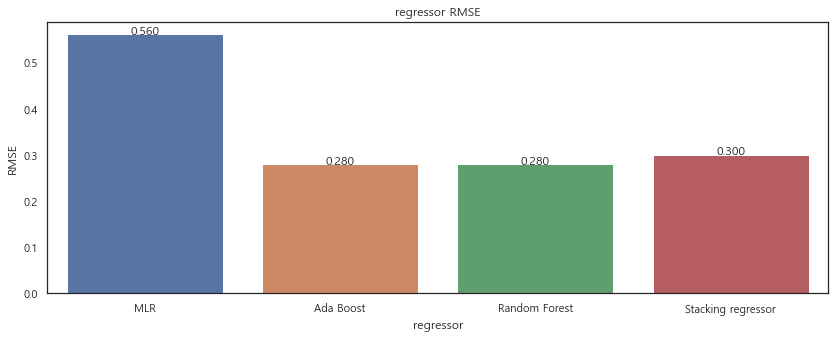

In [73]:
fig, ax = plt.subplots( figsize=(14,5) )
sns.barplot(x = final['regressor'], y = final['RMSE'])
plt.title('regressor RMSE')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) , 
            p.get_y() + p.get_height(), 
            f"{p.get_height():.3f}", 
            ha = 'center' ) 